# Seasonal means along the 3-year period

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
import seaborn as sns
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import cm
from os.path import exists

ProgressBar().register()

## UCAN-WRF433

Open the virtual data set for daily (`day`) data interpolated to the regular lon-lat grid (CSAM-4i):

In [2]:
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/ncml/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/day/v20220727/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_day_v20220727'
ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
ds

<xarray.Dataset>
Dimensions:    (lon: 676, lat: 451, time: 1096, bnds: 2)
Coordinates:
  * lon        (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat        (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
  * time       (time) datetime64[ns] 2018-06-01T11:30:00 ... 2021-05-31T11:30:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(100, 2), meta=np.ndarray>
    hurs       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    rsds       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    sfcWind    (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tasmin     (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                    CF-1.8
    history:                        Thu Jul 14 18:16:58 2022: cdo remap,desti...
    institution:                    Instituto de Fisica de Cantabria, CSIC-Un...
    creation_date:                  2022-07-13-T09:18:06Z
    experiment:                     Evaluation run with ECMWF ERA5 reanalysis...
    experiment_id:                  FPS-SESA
    ...                             ...
    comment:                        Simulation performed at CESGA (https://ww...
    CDO:                            Climate Data Operators version 1.9.8 (htt...
    CORDEX_domain:                  CSAM-4i
    contact:                        meteo@unican.es
    size:                           2147483647
    size_human:                     6.0 GiB

This loaded the full dataset (3 years and all variables) information into `ds`. Variables can be accessed as attributes of this object:

Average seasonal rainfall in mm/day:

In [13]:
yseasmean = ds.pr.resample(time = 'QS-DEC').mean(dim='time').compute() * 86400.

[########################################] | 100% Completed |  1min 58.3s


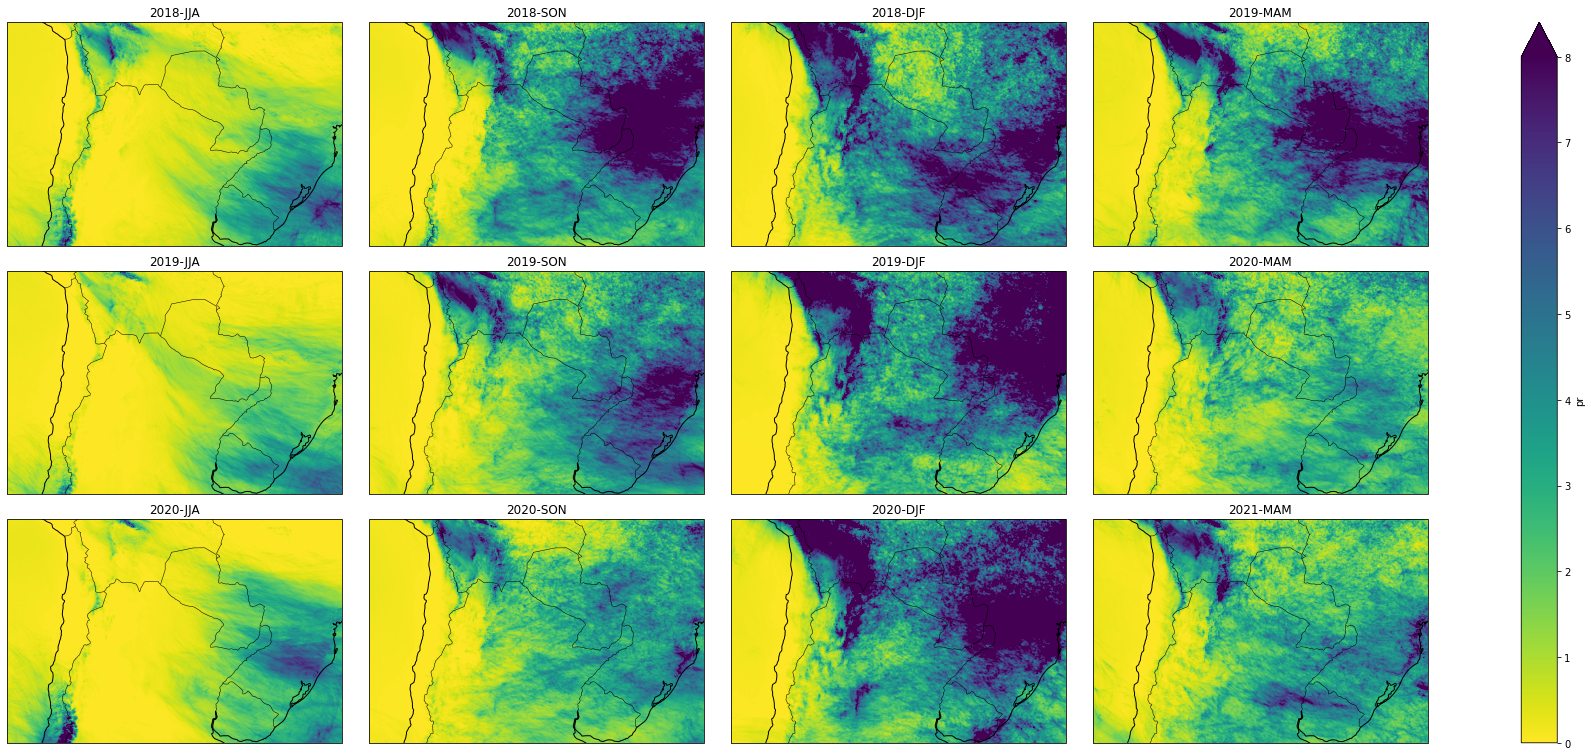

In [56]:
def facet_plot(yseasmean):
  fg = yseasmean.plot(col='time', col_wrap=4,
    size=3.5, aspect=1.8, cmap=cm.viridis_r, vmax=8,
    subplot_kws = dict(projection=ccrs.PlateCarree())
  )
  for ax, yr, sea in zip(fg.axes.ravel(), yseasmean.time.dt.year.values, yseasmean.time.dt.season.values):
    ax.add_feature(cfea.COASTLINE, linewidth=1)
    ax.add_feature(cfea.BORDERS, linewidth=0.5)
    ax.set_title(f'{yr}-{sea}')
    
facet_plot(yseasmean)

## Observations (MSWX)

Load a virtual dataset prepared for the CORDEX FPS-SESA, interpolatd to the common CSAM-4i grid and aggregating times and variables.

In [42]:
fname = 'yseasmean_obs.nc'

if exists(fname):
  yseasmean_obs = xr.open_dataset(fname)
else:
  mswx_url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/mswx/CSAM-4i_GloH2O-MSWX_3hr'
  obs = xr.open_dataset(mswx_url, chunks = dict(time = 100, lon = 100, lat = 100))
  yseasmean_obs = obs.pr.resample(time = 'QS-DEC').mean(dim='time').compute() * 86400. # 3h flux to mm/day

In [42]:
yseasmean_obs.to_netcdf(fname, format = 'NETCDF4', encoding=dict(pr={'zlib':True}))

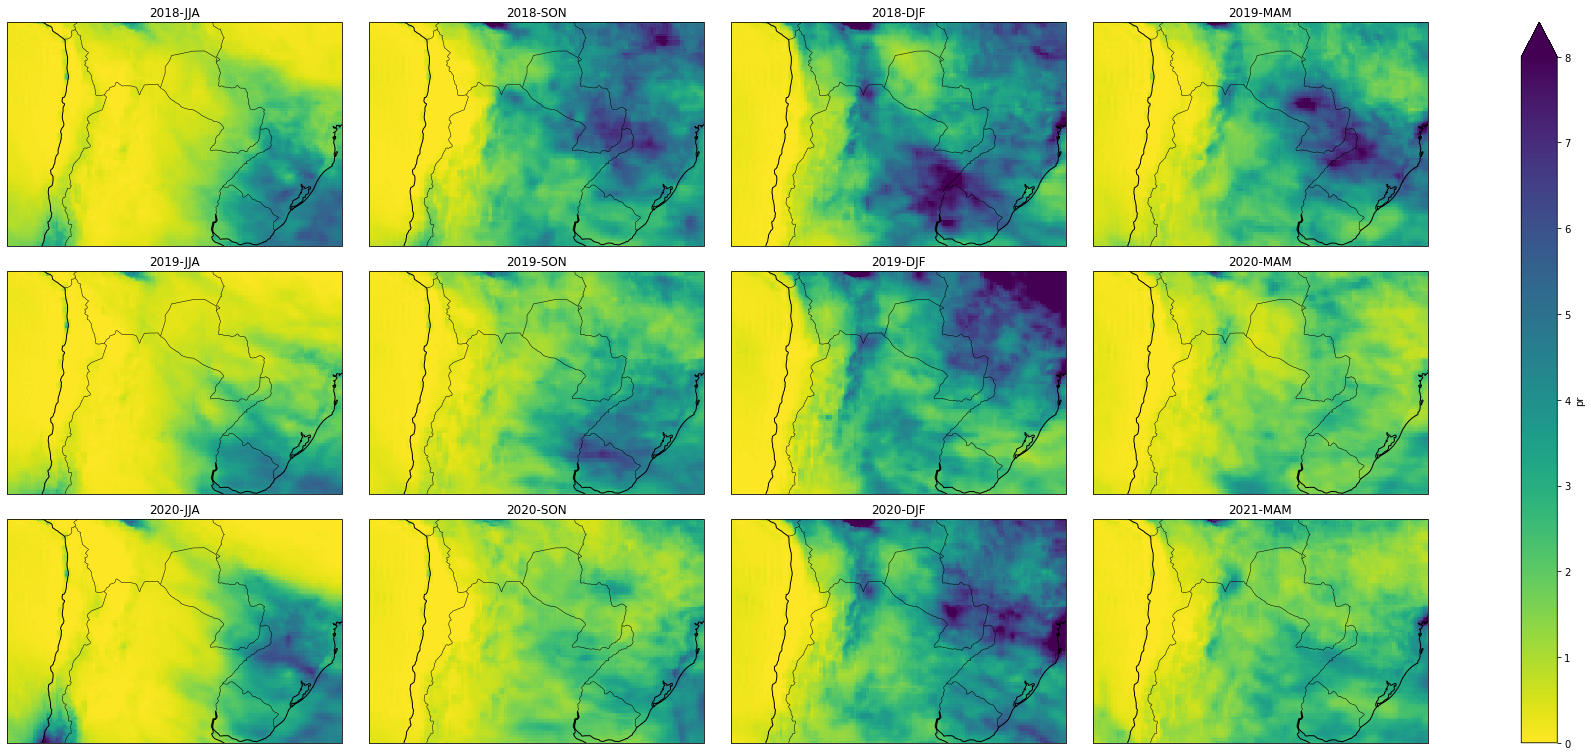

In [58]:
facet_plot(yseasmean_obs.sel(dict(time=slice('2018-06-01','2021-05-31'))))

## ERA5

In [63]:
def load_yseasmean(nc, url, var, scale = 1.0):
  if exists(nc):
    yseasmean = xr.open_dataset(fname)
  else:
    ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
    yseasmean = ds[var].resample(time = 'QS-DEC').mean(dim='time').compute() * scale
    yseasmean.to_netcdf(nc, format = 'NETCDF4', encoding={var:{'zlib':True}})
  return(yseasmean)
    
urls = dict(
  era5 = 'pr_ERA5-CSAM-4i_day_20180101-20211231.nc'
)
yseasmean_era5 = load_yseasmean('yseasmean_era5.nc', urls['era5'], 'pr', 86400. )

[########################################] | 100% Completed | 21.0s
[########################################] | 100% Completed | 21.0s


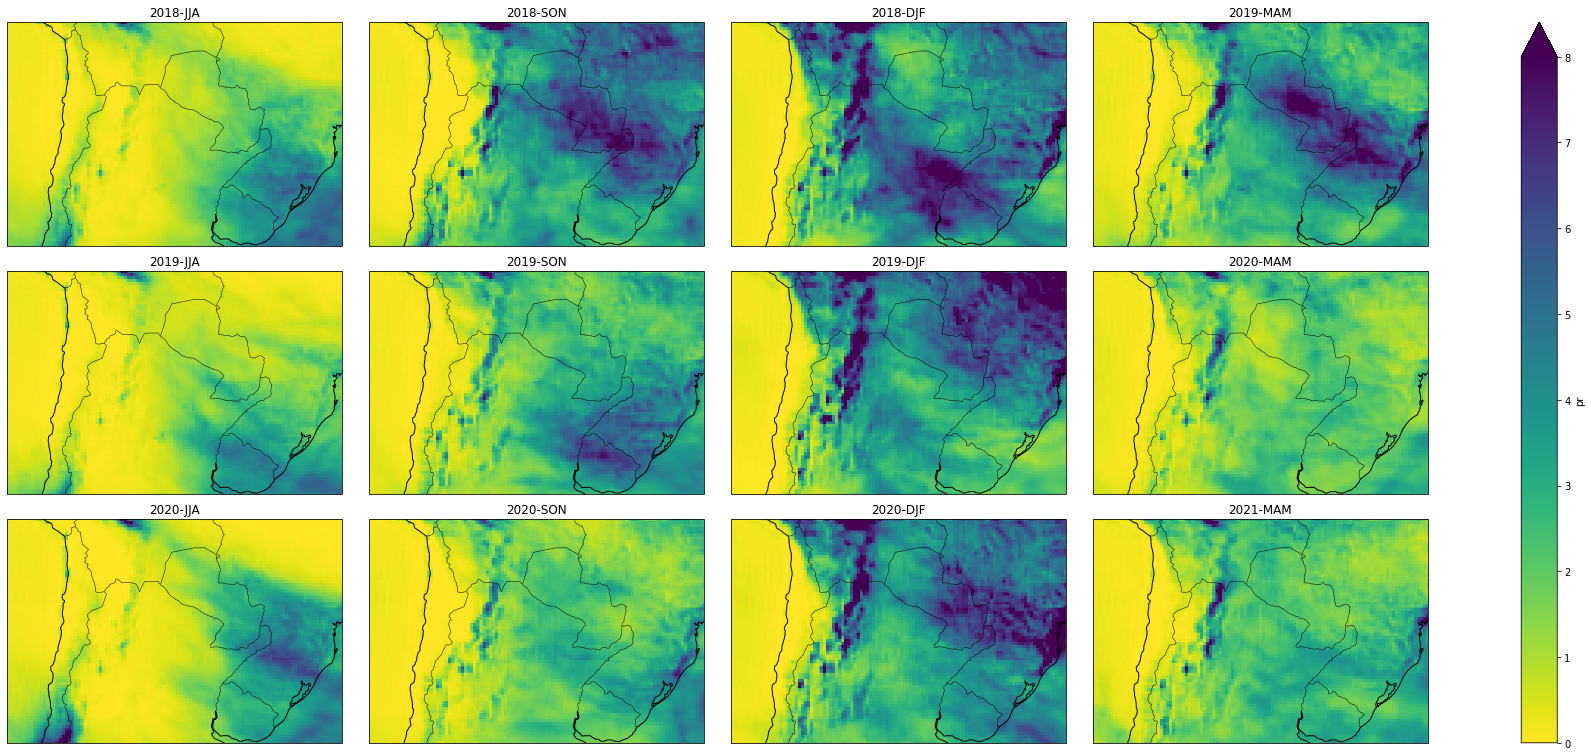

In [65]:
facet_plot(yseasmean_era5.sel(dict(time=slice('2018-06-01','2021-05-31'))))